In [1]:
import veloxchem as vlx

import numpy as np

# Excited-state analysis
In this notebook, we will illustrate how to perform excited state analysis based on linear response TDDFT results in [VeloxChem](veloxchem.org). VeloxChem features an ExcitedStateAnalysis driver based on the transition density matrix which implements some of the excited state descriptors from [J. Chem. Phys. 141, 024106 (2014)](https://doi.org/10.1063/1.4885819). We will calculate the descriptors for a small donor-acceptor (DA) molecule, thienyl-thiazole.

In [2]:
thienyl_thiazole_xyz = """
15

C             -2.166567672964         0.313202106795        -1.071674934650
C             -2.080411655087         1.658890748544        -0.754536692329
S             -0.554021170961         2.069421191262        -0.054372064726
C              0.002025319127         0.415293509320        -0.177856865671
C             -0.978159137707        -0.398203353705        -0.742960550357
C              1.334466165114         0.091357832688         0.289886892105
N              2.176716511993         0.963152548206         0.810542073077
C              3.356151631070         0.369308861442         1.160279723016
C              3.449348155576        -0.988023484243         0.913955708515
S              1.977540876713        -1.559099336277         0.203328303396
H             -3.055949212391        -0.148672419644        -1.526305288569
H             -2.841345775207         2.438956152932        -0.896843728791
H             -0.837203807959        -1.476941876284        -0.913086590031
H              4.157887013088         0.976925929313         1.609453961619
H              4.288034413777        -1.669818398859         1.108225187542
"""

In [3]:
molecule = vlx.Molecule.from_xyz_string(thienyl_thiazole_xyz)
basis = vlx.MolecularBasis.read(molecule, "def2-sv(p)")

molecule.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [4]:
# vlx.available_functionals()

First, we need to perform a DFT calculation to determine the ground-state electronic structure. We will use the CAM-B3LYP functional for this purpose.

In [5]:
scf_drv = vlx.ScfRestrictedDriver()
scf_drv.xcfun = "cam-b3lyp"

scf_results = scf_drv.compute(molecule, basis)

                                                                                                                          
                                            Self Consistent Field Driver Setup                                            
                                                                                                                          
                   Wave Function Model             : Spin-Restricted Kohn-Sham                                            
                   Initial Guess Model             : Superposition of Atomic Densities                                    
                   Convergence Accelerator         : Two Level Direct Inversion of Iterative Subspace                     
                   Max. Number of Iterations       : 50                                                                   
                   Max. Number of Error Vectors    : 10                                                                   
                

Before calculating the excited states and performing the excited state analysis, it's a good idea to have a look at the GS orbitals. This can easily be done using the OrbitalViewer.

In [6]:
orb_viewer = vlx.OrbitalViewer()

In [7]:
orb_viewer.plot(molecule, basis, scf_drv.molecular_orbitals)

Dropdown(description='Alpha orbital', index=42, options=(('  1 occ=2.000 ene=-88.958  (alpha HOMO-42)', 0), ('…

Output()

In thienyl-thiazole, the CAM-B3LYP functional predicts both HOMO and LUMO as delocalized over the entire molecule. Instead, HOMO-1 is localized over the thiophene ring. Transitions from this orbital will contribute to charge transfer excited states, as we will see below. Let us calculate the excited states using linear response TDDFT.

In [8]:
nstates = 10

lr_drv = vlx.LinearResponseEigenSolver()
lr_drv.nstates = nstates

In [9]:
lr_results = lr_drv.compute(molecule, basis, scf_results)

                                                                                                                          
                                            Linear Response EigenSolver Setup                                             
                                                                                                                          
                               Number of States                : 10                                                       
                               Max. Number of Iterations       : 150                                                      
                               Convergence Threshold           : 1.0e-04                                                  
                               ERI Screening Threshold         : 1.0e-12                                                  
                               Exchange-Correlation Functional : CAM-B3LYP                                                
                

The results of the linear response calculation are stored in the output dictionaries. The main result is the absorption spectrum, which can be plotted using the `plot_uv_vis` routine available through the `LinearResponseEigenSolver`.

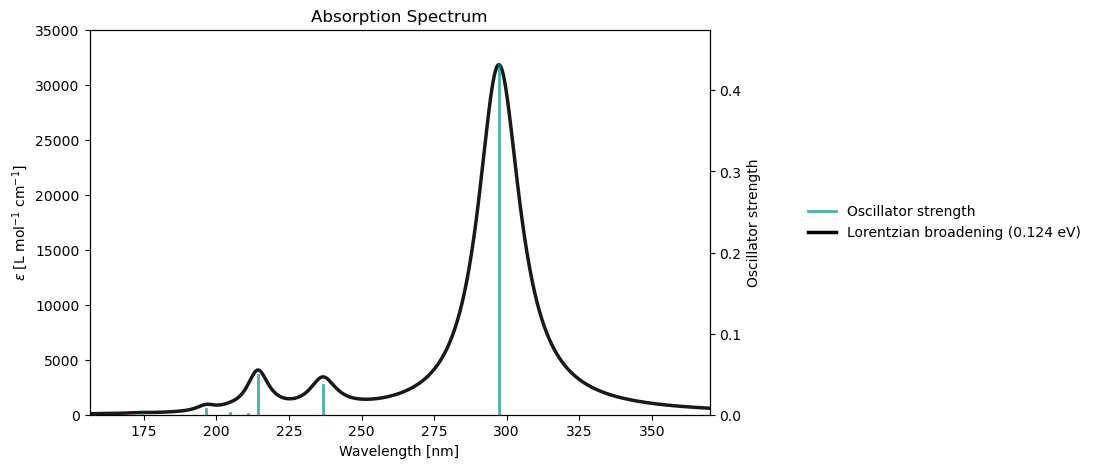

In [10]:
lr_drv.plot_uv_vis(lr_results)

# Visual Analysis of Electronic Transitions

The excited states calculated using VeloxChem can be directly analyzed using the [VALET](https://github.com/tbmasood/VALET) Python library, providing a visual way to determine the nature of the excited states: local excitations or charge transfer. To perform the analysis, we first need to divide the molecule into relevant fragments or subgroups.

In [11]:
molecule.show(atom_indices=True)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [12]:
fragment_dict = {}
fragment_dict["thienyl"] = [1, 2, 3, 4, 5, 11, 12, 13]
fragment_dict["thiazole"] = [6, 7, 8, 9, 10, 14, 15]

In [13]:
valet_drv = vlx.ValetAnalyzer()

# Optionally adjust visualization settings
valet_drv.density_isovalue = 0.001
valet_drv.density_opacity = 0.7

# Define fragment groups (1-based indexing)
# Each tuple is (name, atom_index) or (name, [list_of_atom_indices])
subgroups = [
    ('thienyl', fragment_dict["thienyl"]),
    ('thiazole', fragment_dict["thiazole"])
]

valet_drv.initialize(molecule, basis, subgroups)

# Show the interactive viewer
valet_drv.show(scf_results, lr_results)

Molecule: 15 atoms
Basis: DEF2-SV(P)
Visualizing 10 excited states


Dropdown(description='State:', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10), value=1)

## Excited-state descriptors

Besides the VALET analysis, VeloxChem implements several excited state descriptors which allow to charcaterize the excited states as local excitations (LE) or charge-transfer (CT) states. This analysis is performed based on the transition density matrix, essentially constructed using the excitation vectors from the linear response calculation.

$$
\mathbf{T}_n = \begin{pmatrix} 0 & \mathbf{X}_n\\ \mathbf{Y}^\mathrm{T}_n & 0 \end{pmatrix}
$$

###  Particle and hole densities

From the transition density matrix, we can construct hole and particle densities as [[PWD14, Eq(44)]](https://doi.org/10.1063/1.4885819).
$$
\begin{align}
\rho_\mathrm{H}(\mathbf{r}_\mathrm{H}) &= \sum_{p,q} \left[\mathbf{T}_n \mathbf{T}_n^\mathrm{T} \right]_{pq}\phi_p(\mathbf{r}_\mathrm{H}) \phi_q(\mathbf{r}_\mathrm{H})
\end{align}
$$

$$\rho_\mathrm{E}(\mathbf{r}_\mathrm{E}) =\sum_{p,q} \left[\mathbf{T}^\mathrm{T}_n \mathbf{T}_n \right]_{pq}\phi_p(\mathbf{r}_\mathrm{E}) \phi_q(\mathbf{r}_\mathrm{E}) $$

The particle and hole densities give similar information to the [attachment/detachment densities](https://kthpanor.github.io/echem/docs/visualize/exc_vis.html) and track where **from** and where **to** charge is moving during excitation.

From the particle and hole density plots, we can get a visual understanding of the charge transfer process but we can also use the transition density matrix to obtain quantitative descriptors of the charge transfer and delocalization. 

### Charge transfer matrix
For example, we can partition the densities over different molecular fragments and track how charge is moving between them during the excitation. One way of partitioning is provided by the charge transfer numbers.

\begin{align}
\Omega_{AB} &= \frac{1}{4}\sum_{\mu, \nu} \sum_{\xi, \zeta} T_{n, \mu \nu} T_{n, \xi \zeta} S_{\mu \xi} \left([\mu \in A] + [\xi \in A] \right) S_{\nu \zeta}\left([\nu \in B] + [\zeta \in B] \right) = \\
&=\frac{1}{2}\sum_{\mu \in A} \sum_{\nu \in B} \left[T_{f, \mu \nu} (\mathbf{S} \mathbf{T}_f \mathbf{S})_{\mu \nu} + (\mathbf{S} \mathbf{T}_f)_{\mu \nu} (\mathbf{T}_f \mathbf{S})_{\mu \nu} \right]
\end{align}

Where the Greek indices indicate atomic orbitals and the partial overlap integrals are defined by $S^{\mathrm{(A)}}_{\mu \xi} = \frac{1}{2}\left([\mu \in A] + [\xi \in A] \right)S_{\mu \xi}$. The "Iverson bracket" $[X]$ is $1$ if the statement inside is true and $0$ if it is false. 

### Participation ratios
In order to quantify the delocalization of the excitation, we can use the so-called participation ratio (PR) descriptor. First, we define the hole ($p_{A \rightarrow}$) and particle ($p_{A \leftarrow}$) fragment weights
$$p_{A \rightarrow} = \frac{1}{\Omega} \left(\Omega_{AA} + \Omega_{AB}\right)$$
$$p_{A \leftarrow} = \frac{1}{\Omega} \left(\Omega_{AA} + \Omega_{BA}\right)$$
By taking the inverse of the sum of the squared hole weights for all fragments we get the hole participartion ratio [[PL12, Eq(18)]](https://doi.org/10.1021/ct300307c)
$$\mathrm{PR}_\mathrm{H} = \frac{1}{p_{A \rightarrow}^2 + p_{B \rightarrow}^2}$$

$\mathrm{PR}_\mathrm{H}$ holds information about how many of our fragments the initial orbital (hole) was delocalized over. 

Similarly, we define the particle participation ratio [[PL12, Eq(19)]](https://doi.org/10.1021/ct300307c)
$$\mathrm{PR}_\mathrm{E} = \frac{1}{p_{A \leftarrow}^2 + p_{B \leftarrow}^2}$$ 
$\mathrm{PR}_\mathrm{E}$ holds information about how many of our fragments the final orbital (particle) is delocalized over.

### Average particle and hole positions
We can also also use the charge transfer numbers to calculate the average position of the hole and particle. We do this by multiplying the ratios from the PR section with the geometric center of each fragment. $\mathbf{r}_\mathrm{H}$ is the average position of the hole and $\mathbf{r}_\mathrm{E}$ the average position of the particle. The equation becomes [[PL12, Eq(23, 24)]](https://doi.org/10.1021/ct300307c)
$$\mathbf{r}_\mathrm{H} = \mathbf{r}_A \; p_{A \rightarrow} + \mathbf{r}_B \; p_{B \rightarrow}$$
$$\mathbf{r}_\mathrm{E} = \mathbf{r}_A \; p_{A \leftarrow} + \mathbf{r}_B \; p_{B \leftarrow} $$

where $\mathbf{r}_A$ and $\mathbf{r}_B$ are the coordinates of the geometric center of each fragment.

The construction of particle and hole densities, as well as computation of the descriptors listed above is enabled in [VeloxChem](veloxchem.org) by the `ExcitedStateAnalysisDriver`. To carry out this analysis, we must first define our molecular fragments. A natural partitioning is to divide the molecule into two fragments, one corresponding to the thienyl moiety and the other to the thiazole moiety,

In [14]:
molecule.show(atom_indices=True)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [15]:
ex_analysis = vlx.ExcitedStateAnalysisDriver()
ex_analysis.fragment_dict = fragment_dict

Now that we have our fragments, let's calculate the descriptors.

In [16]:
full_analysis = {}

In [17]:
for i in range(nstates):
    analysis_results = ex_analysis.compute(molecule, basis, scf_results, lr_results, state_index=i+1)
    key = "S%d" % (i + 1)
    full_analysis[key] = analysis_results

                                                                                                                          
                                                 Excited State Analysis.                                                  
                                                                                                                          
                               Excited state analysis based on : transition density matrix                                
                               Excited state index             : 1                                                        
                               Fragment thienyl                : 1, 2, 3, 4, 5, 11, 12                                    
                                                                 13                                                       
                               Fragment thiazole               : 6, 7, 8, 9, 10, 14, 15                                   
                

Besides the values of the descriptors, saved in the `full_analysis` dictionary, we have the possibility of visualizing the average positions of the particle and hole, as well as visualize the particle and hole densities.

In [18]:
ex_analysis.show_avg_ph_position(molecule, full_analysis["S3"])

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [19]:
ex_analysis.show_density(molecule, basis, full_analysis["S3"])

IntProgress(value=0, bar_style='info', description='Loading:', max=14, style=ProgressStyle(bar_color='#44aa44'…

Dropdown(description='Density', options=('particle', 'hole'), value='particle')

Output()

## Excited-state analysis based on results from an h5 file

The `ExcitedStateAnalysisDriver` can also read the SCF and response results from file.

In [5]:
ex_analysis = vlx.ExcitedStateAnalysisDriver()

scf_res, rsp_res = ex_analysis.read_from_h5("output_files/D0_A9_conformer1_cam_lr.h5")
molecule, basis = ex_analysis.create_molecule_and_basis(scf_res)

In [6]:
molecule.show(atom_indices=True)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

After reading the results from file and creating the molecule and basis, the analysis is performed exactly the same way as before. We have to define the fragments and then run the analysis.

In [8]:
fragment_dict = {}
fragment_dict["D0"] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 31, 32, 33, 34]
fragment_dict["A9"] = [17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 35, 36]

In [9]:
ex_analysis.fragment_dict = fragment_dict

In [10]:
nstates = len(rsp_res["eigenvalues"])

full_analysis_from_h5 = {}

for i in range(nstates):
    analysis_results = ex_analysis.compute(molecule, basis, scf_res, rsp_res, state_index=i+1)
    key = "S%d" % (i + 1)
    full_analysis_from_h5[key] = analysis_results

                                                                                                                          
                                                 Excited State Analysis.                                                  
                                                                                                                          
                               Excited state analysis based on : transition density matrix                                
                               Excited state index             : 1                                                        
                               Fragment D0                     : 1, 2, 3, 4, 5, 6, 7                                      
                                                                 8, 9, 10, 11, 12, 13, 14                                 
                                                                 15, 16, 31, 32, 33, 34                                   
                

In [13]:
ex_analysis.show_avg_ph_position(molecule, full_analysis_from_h5["S2"])

3Dmol.js failed to load for some reason. Please check your browser console for error messages.